### Natural Language Processing Guide
#### Cornell Data Science
##### Author: Christopher Elliott

#### Installation Guide
Before starting the guide: the lastest release of Anaconda should install all of the modules used in this guide **except** spaCY. You **MUST** install spaCY to use many parts of this guide. If spaCy is not installed, some modules will **NOT** work. to install spaCY run "pip install -U spacy" in your terminal or command prompt. Additonally, run "python -m spacy download en_core_web_sm" to download the corpus used in this guide. For more information please go to https://spacy.io/usage/

In [1]:
#Import modules
import nltk
from nltk import word_tokenize as wtk
import urllib
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import spacy
from PIL import Image

## Text Scrapping and Word Tokenization from online sources

In [2]:
#Scraping utf8 txt from the Guetenburg Project Website (The Adventures of Sherlock Holmes: Doyle)
website = "http://www.gutenberg.org/cache/epub/1661/pg1661.txt"
webresponse = urllib.request.urlopen(website)
raw_txt = webresponse.read().decode('utf8')

# Now that the raw text is a string, it is possible to tokenize the words.
# Luckily, the NLTK module can tokenize large strings automatically.
# Tokenzation is the process in which a string of sentences is broken up into words and puncuation. This is important
# as it allows for further statistical analysis.
tokenized = wtk(raw_txt)

#Manually Find the Beginning of the Text
beginning = raw_txt.find("*** START OF THIS PROJECT GUTENBERG EBOOK THE ADVENTURES OF SHERLOCK HOLMES ***")

#Manually Find the End of the Text
end = raw_txt.find("End of the Project Gutenberg EBook ") 
raw_txt= raw_txt[beginning:end]

#Parse the list of words into a NLTK 'text' object
text = nltk.Text(tokenized)

Now that we have created a NLTK text object, we can use methods in the NLTK module to tokenize specific words in the text. Doing this is an important step in text preprocessing as it allows for data scientists to get a better understanding of which words in the text are more important than others.

In [3]:
# The first step in tokenizing words is to remove puncuation from the text and convert the text to lowercase.
# This is important as it make for only important key words to tokenized once.

#filters tokenized words
alpha = [wrd.lower() for wrd in text if wrd.isalpha()]
text = nltk.Text(alpha)

# Once the text is converted into lowercase and puncuation is removed, It is possible to create of collection of words
# with thier total frequencies in the text This is known as a bag of words. This can be used to 
# identifity topics in a text. This is a good way of also identifying the overall significance of a word in a text. 

#Basic Bag of Words
basic_bag_of_words = Counter(text)
basic_bag_of_words.most_common(10)

[('the', 5793),
 ('and', 3061),
 ('i', 2990),
 ('of', 2777),
 ('to', 2761),
 ('a', 2693),
 ('in', 1818),
 ('that', 1757),
 ('it', 1736),
 ('you', 1536)]

Looking at the most common words in the tokenized text above, you may notice that the words with the highest frequencies are  articles and do not really give any insight about the text. This is because many of the most common words in this bag of words are considered 'stop words'. Stop words are words which appear in a text that are exceptionally common in a language. It is best to remove them so that they do not distrupt the accuracy of any future analysis. The NLTK module has an already defined set of stop words for the english language.  

In [4]:
#Import NLTK's Stop Words Corpus
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

#removing stop words
bag_of_words_no_stop = Counter([word for word in text if word not in stopwords])

bag_of_words_no_stop.most_common(10)

[('said', 486),
 ('upon', 467),
 ('holmes', 466),
 ('one', 374),
 ('would', 333),
 ('man', 303),
 ('could', 288),
 ('little', 269),
 ('see', 232),
 ('may', 210)]

Looking at some of the most common words in the bag of words above, we can now see that the words can give some insight about the text's meaning. In additon to this, the bag of words can now be used for more advanced statical analysis and modeling. 

## Text Classification

Another aspect of Natural Language Processing is classifying text based off of predetermined labels. This practice draws heavily from elements of supervised machine learning and word tokenization practices that were previously discussed. The data set used in this exercise is called the **fake_real_news_dataset** which was created by **George McIntire (geo.mcintire@gmail.com)** 

In [5]:
# Data Set = George McIntire fake_real_news_dataset
df = pd.read_csv('fake_or_real_news.csv')

#Using the Pandas Dataframe head() method, we are able to look at how the dataset is organized 
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


From the heading above we can see that each cell in the csv file holds a different value for each text. For example, the fourth cell holds the label data which we will be using to classify the text. 

In [6]:
# Next step in preprocessing data is to check if there are any missing values in the data set
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

From the output above we can see that there are 0 missing values in the "Unnamed" feature along with the other features for each data point. as a result, we know that are no missing datapoints in this dataset  

In [7]:
# Now that the data has been preprocessed, it is time to split the data set into train and test sets
# a typical convention is to use two-thirds of the dataset for training while leaving the rest of the dataset to evaluate
# our model's accuracy via a "test" set.

# Set the qualitative features into dummy variables before splitting the data into training and test sets

# Also important note: 'y' is often used as the varaible name for the target classification label. In this dataset, y can be
# set into binary notation with 0 indicating a Real news article while 1 indicates a fake news article. 

#Converting y into a binary label 
y = pd.get_dummies(df['label'])
y = y['FAKE']

#Setting x to all of the text in the article
x = df['text']

#Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.10, random_state = 53)


In [8]:
# In order to processs text efficiently, it is nessecary to use a CountVectorizer. A Count Vectorzier takes text
# and converts it to Bag of Words vectors while removing stop words as well as punctuation. The Count Vectorizer is
# called on both the training and test set to create a bag of words vector for each of the sets. 

# Initialize a CountVectorizer
cv = CountVectorizer()

#Call the Count Vectorizer on each of the sets 
count_train = cv.fit_transform(X_train.values)
count_test = cv.transform(X_test.values)

In [9]:
# Initialize the Multinomial Naive Bayes Classifier
classifier = MultinomialNB()

#Fit the Classifier to the training set 
classifier.fit(count_train,y_train)

#Run predictions for test set  
predict = classifier.predict(count_test)

#Evaluate the accuracy of the model
metrics.accuracy_score(y_test,predict)

0.9053627760252366

## Named Entity Recognition and Parts of Speech Tagging

Named Entity Recognition (NER) is a excerise done in natural language processing used to identify significant entities in text (people, places, events ... etc). It can be used to extract information from large sets of texts quickly.

#### NER using spaCY

In [10]:
#Open Text File
NER_text = open('NER Cornell Wikipedia.txt')
NER_text = NER_text.read()


# In order to do NER, text must be properly preprocessed via tokenization. 

#Tokenize the text
tokenized_text = nltk.word_tokenize(NER_text)


# Once the text is preprocessed, the text needs to be tagged for Parts of Speech (POS). POS tags different aspects
# of speech such as pronouns verbs and adjectives that are found in the text. This is done by examining the rules of grammer
# in the english language. 

#Parts Of Speech tagging
tagged_text = nltk.pos_tag(tokenized_text)

# Finally, the tagged text is passed into the ne_chunck() method to return the sentence as a tree. Using the chunck method
# on the tagged text will return specifc words in the text tagged with thier own words. You can read what each tag represents
# in the link below:

# Link to Penn Parts of speech Guide: https://cs.nyu.edu/grishman/jet/guide/PennPOS.html

print(nltk.ne_chunk(tagged_text))

(S
  (ORGANIZATION Cornell/NNP University/NNP)
  is/VBZ
  a/DT
  private/JJ
  and/CC
  statutory/JJ
  (ORGANIZATION Ivy/NNP League/NNP)
  research/NN
  university/NN
  located/VBN
  in/IN
  (GPE Ithaca/NNP)
  ,/,
  (GPE New/NNP York/NNP)
  ./.
  Founded/VBN
  in/IN
  1865/CD
  by/IN
  (PERSON Ezra/NNP Cornell/NNP)
  and/CC
  (PERSON Andrew/NNP Dickson/NNP White/NNP)
  ,/,
  the/DT
  university/NN
  was/VBD
  intended/VBN
  to/TO
  teach/VB
  and/CC
  make/VB
  contributions/NNS
  in/IN
  all/DT
  fields/NNS
  of/IN
  knowledge—from/NN
  the/DT
  classics/NNS
  to/TO
  the/DT
  sciences/NNS
  ,/,
  and/CC
  from/IN
  the/DT
  theoretical/JJ
  to/TO
  the/DT
  applied/VBN
  ./.
  These/DT
  ideals/NNS
  ,/,
  unconventional/JJ
  for/IN
  the/DT
  time/NN
  ,/,
  are/VBP
  captured/VBN
  in/IN
  (GPE Cornell/NNP)
  's/POS
  motto/NN
  ,/,
  a/DT
  popular/JJ
  1865/CD
  Ezra/NNP
  Cornell/NNP
  quotation/NN
  :/:
  ``/``
  I/PRP
  would/MD
  found/VB
  an/DT
  institution/NN
  where/WRB
 

#### NER and POS using spaCY

In [11]:
#Load spaCY english language core
nlp = spacy.load('en_core_web_sm')

#Parse the text into the nlp object to create a spaCY document object with the text
document = nlp(NER_text)

# Once the document is created, the NER entities are stored under the attribute ents while the label is stored 
# under the attribute ent  

for i in range (0,10):
    print(document.ents[i] , document.ents[i].label_)

Cornell University ORG
Ithaca PERSON
New York GPE
1865 DATE
Ezra Cornell PERSON
Andrew Dickson White PERSON
Cornell ORG
1865 DATE
Ezra Cornell PERSON

 GPE


While NLTK and spaCY both are capable of doing NER, spaCY has a great interactive visualization tool called displaCy that can be used in demos and presentations.

In [12]:
#Sample code for how displaCY can be used for NER visualization.
spacy.displacy.serve(document, style='ent')


    Serving on port 5000...
    Using the 'ent' visualizer


    Shutting down server on port 5000.



###### Visualization Example:

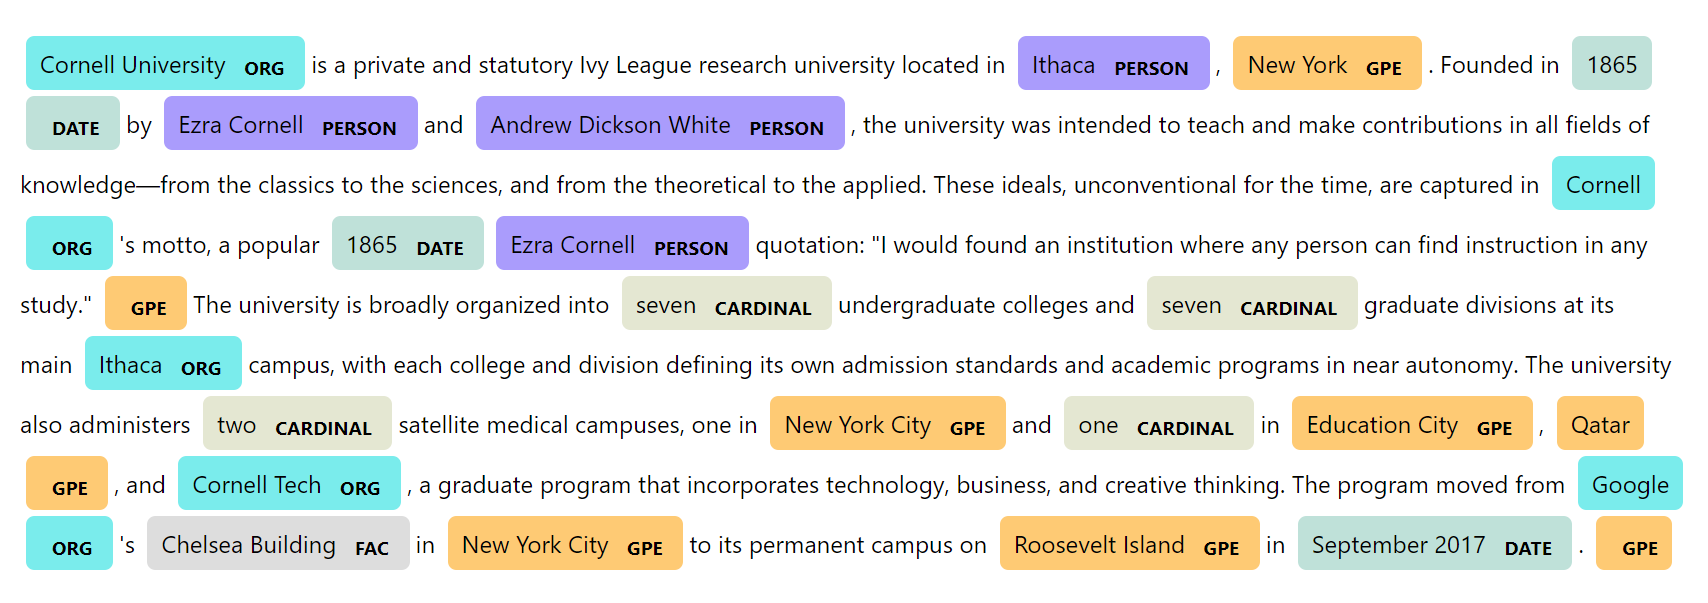

In [262]:
from IPython.display import Image
Image('displaCY demo.png')